In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import gymnasium as gym
import ast

from FFNN import FFNN
from blackjackenv_extended import BlackjackEnv

from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

seed = 27
np.random.seed(seed)

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


using cpu


## Blackjack

In [3]:
env = BlackjackEnv(natural=True)

episodes = 75000
collect_data = True

In [4]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}

def one_hot_encode(observation, n):
    one_hot = np.zeros(n)
    one_hot[observation] = 1
    return one_hot

def play_game(env, episodes, agent, collect_data=False, print_rewards=True, OH_encode=False):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            if OH_encode:
                observation = one_hot_encode(observation, env.observation_space.n)
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            
            if OH_encode:
                agent.learn(observation, 
                            action, 
                            reward, 
                            one_hot_encode(next_observation, env.observation_space.n), 
                            terminated or truncated)
            else:  
                agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    if print_rewards:
        #print("Rewards: ", rewards)
        print("Average Reward: ", average_reward)
        print("Variance: ", variance)
    
    return rewards

In [5]:
def plot_reward(data, title, filename, labels, plot_variance=False, rolling_length=1000):
    data = np.array(data)
    np.savetxt(f'../data/{filename}_rewards.csv', data.reshape(data.shape[0], -1), delimiter=',')
    
    _, ax = plt.subplots()
    
    rolling_mean = np.zeros((len(data), len(data[0]) - (rolling_length - 1))) 
    for i in range(len(data)):
        rolling_mean[i] = (np.convolve(np.array(data[i]).flatten(), np.ones(rolling_length), mode="valid")
            / rolling_length)
            
    if plot_variance:
        mean = rolling_mean.mean(axis=0)
        variance = rolling_mean.var(axis=0)
        upper_bound_sd = mean + np.sqrt(variance)
        lower_bound_sd = mean - np.sqrt(variance)
        plt.plot(mean, label='Mean', color='blue')
        plt.fill_between(range(len(mean)),upper_bound_sd, lower_bound_sd, alpha=0.2, label='Standard Deviation')
    else:
        for i in range(len(data)):
            ax.plot(rolling_mean[i], label=labels[i])

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.legend()
    plt.savefig(f"../figures/{filename}_rewards.png", dpi='figure', format=None)
    plt.show()

### Random & Basic Agents

100%|██████████| 75000/75000 [00:09<00:00, 8222.75it/s]


Average Reward:  -0.48979333333333336
Variance:  1.500245827234847


100%|██████████| 75000/75000 [00:08<00:00, 8570.97it/s]


Average Reward:  -0.006886666666666667
Variance:  1.2793329649291436


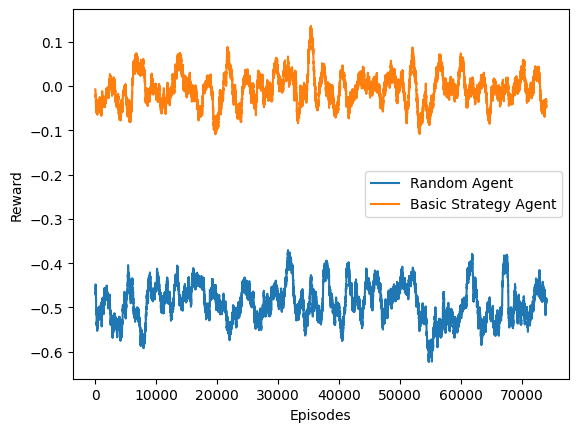

In [5]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)


agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_random, rewards_basic_strategy], "Random vs Basic Strategy Agent", "random_basic_strategy", ["Random Agent", "Basic Strategy Agent"])

## Data Generation

### Simulated Data

In [7]:
def read_data(file):
    return pd.read_csv(file, delimiter=',')

In [8]:
def split_data(data):
    x = data[:, :5]
    y = data[:, 5]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    return x_train, x_test, y_train, y_test

def transform(data):
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [9]:
def preprocess(filename):
    df_raw = read_data(filename)
    print(df_raw.head())
    d_raw = df_raw.to_numpy() # data to binary?
    x, x_test, y, y_test = split_data(d_raw)
    x, x_test = transform(x), transform(x_test)
    
    return x, x_test, y, y_test

In [10]:
datafile = '../data/basic_strategy_agent.csv'
x_train, x_test, y_train, y_test = preprocess(datafile)

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          20            1           0                    1              1   
1           8            4           0                    1              1   
2          18            4           0                    0              0   
3          21            3           1                    1              0   
4          17           10           0                    1              0   

   Action  
0       0  
1       1  
2       0  
3       0  
4       0  


In [11]:
def one_hot_encode(y, n):
    return torch.eye(n)[y]

def combine_input_and_label(x, y, n):
    y_one_hot = one_hot_encode(y, n)
    return torch.concat((x, y_one_hot), 1)

def generate_neg_labels(y, n):
    y_ = y.copy()
    for i in range(len(y)):
        negative_labels = [j for j in range(n) if j != y[i]]
        y_[i] = np.random.choice(negative_labels)

    return y_

In [12]:
x_pos = combine_input_and_label(x_train, y_train, 4)

y_neg = generate_neg_labels(y_train, 4)
x_neg = combine_input_and_label(x_train, y_neg, 4)

y_train_OH = one_hot_encode(y_train, 4)
y_test_OH = one_hot_encode(y_test, 4)

print(f"x_pos[0]: {x_pos[0]}")
print(f"x_neg[0]: {x_neg[0]}")
print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

x_pos[0]: tensor([15.,  9.,  0.,  1.,  0.,  0.,  1.,  0.,  0.])
x_neg[0]: tensor([15.,  9.,  0.,  1.,  0.,  0.,  0.,  1.,  0.])
Train size: 90406
Test size: 22602


### Balanced Data

In [12]:
env = BlackjackEnv(natural=True)
basic_strategy_agent = BasicStrategyAgent(env, filename='../data/blackjack_combinations')

def create_combinations():
    for player_hand in range(4, 22):
        for dealer_hand in range(2, 12):
            for usable_ace in range(2):
                for can_double_down in range(2):
                    for can_split in range(2):
                        observation = (player_hand, dealer_hand, usable_ace, can_double_down, can_split)
                        if (dealer_hand == 11 and usable_ace) == 1:
                            # impossible combination    
                            continue
                        action = basic_strategy_agent.get_action(observation)
                        basic_strategy_agent.collect_data(observation, action)
    
    basic_strategy_agent.save_data()
                        
            
def get_combinations_for_action(action):
    samples = []
    with open('../data/blackjack_combinations.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if int(row[-1]) == action:
                samples.append(row)
    return samples

def sample_balanced_data(n_samples):
    data = []
    combinations = np.empty(4, dtype=object)
    
    for action in range(4):
        combinations[action] = get_combinations_for_action(action)
        
        for i in range(n_samples):
            sample_idx = np.random.choice(len(combinations[action]))
            data.append(combinations[action][sample_idx])

    with open('../data/balanced_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        
        writer.writerow(["Player sum", "Dealer card", "Usable ace", "Double down allowed", "Split allowed", "Action"])
        writer.writerows(data)

In [13]:
create_combinations()
samples_per_action = 30_000
sample_balanced_data(samples_per_action)

In [14]:
datafile = '../data/balanced_data.csv'
x_train_bal, x_test_bal, y_train_bal, y_test_bal = preprocess(datafile)

x_pos_bal = combine_input_and_label(x_train_bal, y_train_bal, 4)

y_neg_bal = generate_neg_labels(y_train_bal, 4)
x_neg_bal = combine_input_and_label(x_train_bal, y_neg_bal, 4)

y_train_OH_bal = one_hot_encode(y_train_bal, 4)
y_test_OH_bal = one_hot_encode(y_test_bal, 4)


print(f"\nx_pos[0]: {x_pos_bal[0]}")
print(f"x_neg[0]: {x_neg_bal[0]}")
print(f"\nTrain size: {len(x_train_bal)}")
print(f"Test size: {len(x_test_bal)}")

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          20            8           1                    1              1   
1          16            6           0                    0              0   
2          21            9           0                    1              1   
3          18           10           0                    1              0   
4          13            2           0                    0              1   

   Action  
0       0  
1       0  
2       0  
3       0  
4       0  

x_pos[0]: tensor([21.,  7.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])
x_neg[0]: tensor([21.,  7.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

Train size: 96000
Test size: 24000


## Forward-Forward

In [14]:
def print_accuracy(model_predictions, y):
    predictions = np.array(torch.Tensor.cpu(model_predictions)).flatten()
    accuracy =  model_predictions.eq(torch.from_numpy(y).to(device)).float().mean().item()
    
    print(y)
    print(predictions)
    print(f'Accuracy: {accuracy}')

    ConfusionMatrixDisplay.from_predictions(y, predictions, normalize="true")
    
def plot_accuracy(data, title, filename):
    np.savetxt(f'../data/{filename}_accuracy.csv', data, delimiter=',')

    plt.plot(np.array(data))

    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(f"../figures/{filename}_accuracy.png", dpi='figure', format=None)
    plt.show()

### Balanced Data FFNN

In [16]:
# Hyperparameters
layers = [9, 2000, 2000, 2000, 2000]
threshold = 5
learning_rate = 0.001
epochs = 240
batch_size = 64
lr_decay = False

model = FFNN(
    device=device,
    layers=layers,
    threshold=threshold,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    ).to(device)


In [17]:
last_layer_accuracy = model.train(x_pos_bal, x_neg_bal)
model.save_model('../models/model_balanced.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 240/240 [10:49<00:00,  2.71s/it]



Training Layer: 2
----------------------------------------


100%|██████████| 240/240 [08:07<00:00,  2.03s/it]



Training Layer: 3
----------------------------------------


100%|██████████| 240/240 [08:05<00:00,  2.02s/it]



Training Layer: 4
----------------------------------------


100%|██████████| 240/240 [08:29<00:00,  2.12s/it]


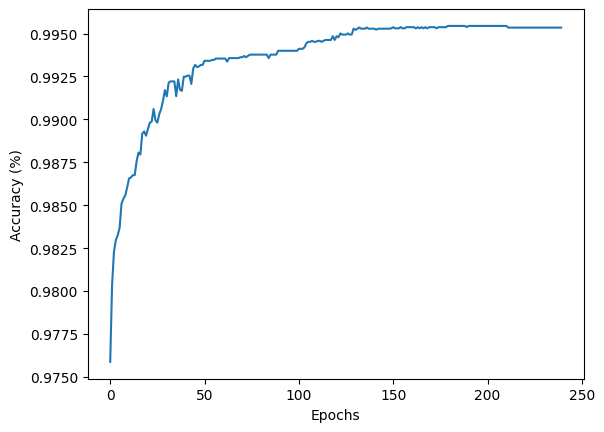

[1 3 1 ... 0 1 2]
[1 3 1 ... 0 1 2]
Accuracy: 0.9996666312217712


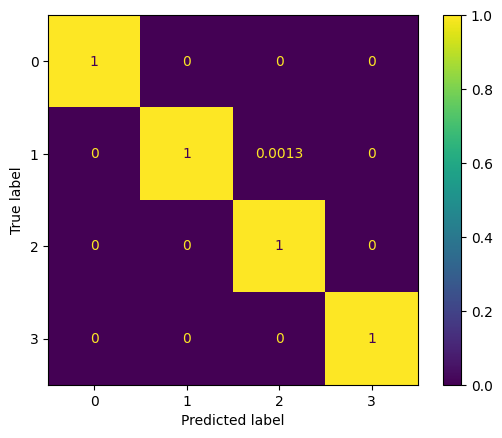

In [18]:
plot_accuracy(last_layer_accuracy, "Training Accuracy Last Layer Balanced Model", "model_balanced")
print_accuracy(model.predict_accumulated_goodness(x_test_bal.to(device)), y_test_bal)

### FFNN

In [22]:
def cross_validation(x_pos, x_neg,architectures, thresholds, learning_rates, n_epochs, n_folds, batch_sizes, lr_decays, save_accuracies=True):
    
    size_subset = len(x_pos) // n_folds
    validation_risks = []
    
    for architecture in architectures:
        for threshold in thresholds:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for lr_decay in lr_decays:
                        #print("-"*40)
                        print(f"Current Model:{architecture}, thr={threshold}, lr={lr}, batch_size={batch_size}, lr_decay={lr_decay}")
                        val_risks_model = []
                        
                        for fold in range(n_folds):
                            #print(f"Fold {fold}")
                            #print("-"*40)
                            
                            # Split data into training and validation
                            start_idx = fold * size_subset
                            end_idx = (fold + 1) * size_subset
                            x_pos_train = torch.cat((x_pos[:start_idx], x_pos[end_idx:]))
                            x_neg_train = torch.cat((x_neg[:start_idx], x_neg[end_idx:]))
                            x_val = x_train[start_idx:end_idx]
                            y_val = y_train[start_idx:end_idx]
                            
                            # Initialize current model
                            model = FFNN(
                                device=device,
                                layers=architecture,
                                bias=True,
                                threshold=threshold,
                                learning_rate=lr,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                lr_decay=lr_decay,
                                verbose=False
                            ).to(device)
                            
                            # Train model
                            last_layer_accuracy = model.train(x_pos_train, x_neg_train)
                            
                            # Compute validation risk
                            predictions = model.predict_accumulated_goodness(x_val.to(device))
                            val_risk = 1 - predictions.eq(torch.from_numpy(y_val).to(device)).float().mean().item()
                            val_risks_model.append(val_risk)
                            
                            if save_accuracies:
                                np.savetxt(f'../data/cxv/{architecture}_th={threshold}_lr={lr}_b={batch_size}_lrdecay={lr_decay}_accuracy{fold}.csv', 
                                           last_layer_accuracy, delimiter=','
                                           )
                            
                        avg_val_risk = np.mean(val_risks_model)
                        se_val_risk = (np.std(val_risks_model, ddof=1)) / np.sqrt(n_folds)
                        validation_risks.append((architecture, threshold, lr, batch_size, lr_decay, val_risks_model, se_val_risk, avg_val_risk ))
                        #model.save_model(f'../models/model_{architecture}_{threshold}_{lr}_{avg_val_risk}.pth')
                        
                        with open('../data/cxv_results.csv', 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow([architecture, threshold, lr, batch_size, lr_decay, val_risks_model, se_val_risk, avg_val_risk])
                            
                        #print(f"validation risks for model {architecture}, thr={threshold}, lr={lr}: {val_risks_model}")
                        print(f"average validation risk: {avg_val_risk}")
                        print("-"*40)
    
    #print("total validation risks:" , validation_risks)  
    min_risk_model = min(validation_risks, key=lambda x: x[-1])
    print(f"Best model: {min_risk_model[:-1]}, with risk: {min_risk_model[-1]}")   
    return min_risk_model               

In [ ]:
# Hyperparameters
architectures = [
    [9,30,30,30,30],
    [9,100,100,100,100],
    [9,500,500,500,500],
    [9,2000,2000,2000,2000],
]
thresholds = [0.1, 0.5, 1, 5, 10]
learning_rates = [0.0001,0.001,0.01,0.03]
n_epochs = 240
n_folds = 5
batch_sizes = [64]
lr_decays = [0]

best_model = cross_validation(
    x_pos, 
    x_neg, 
    architectures,
    thresholds,
    learning_rates,
    n_epochs,
    n_folds,
    batch_sizes,
    lr_decays,
)

Current Model:[9, 30, 30, 30, 30], thr=0.1, lr=0.0001, batch_size=64, lr_decay=0


In [18]:
# Get best model
df = pd.read_csv("../data/cxv_results.csv", header=None) 
df_sorted = df.sort_values(by=df.columns[-1])
df_sorted.columns = ['Architecture', 'Threshold', 'Learning Rate', 'Batch Size', 'LR Decay', 'Validation Risks', 'SE', 'Average Validation Risk']
best_model = df_sorted.head(1)
print(df_sorted.head(10))

                   Architecture  Threshold  Learning Rate  Batch Size  \
77  [9, 2000, 2000, 2000, 2000]       10.0         0.0010          64   
49      [9, 500, 500, 500, 500]        5.0         0.0010          64   
38      [9, 100, 100, 100, 100]       10.0         0.0100          64   
57      [9, 500, 500, 500, 500]       10.0         0.0010          64   
73  [9, 2000, 2000, 2000, 2000]        5.0         0.0010          64   
76  [9, 2000, 2000, 2000, 2000]       10.0         0.0001          64   
53      [9, 500, 500, 500, 500]        5.0         0.0010          64   
72  [9, 2000, 2000, 2000, 2000]        5.0         0.0001          64   
54      [9, 500, 500, 500, 500]        5.0         0.0100          64   
34      [9, 100, 100, 100, 100]        5.0         0.0100          64   

    LR Decay                                   Validation Risks        SE  \
77         0  [0.004092693328857422, 0.0001659393310546875, ...  0.000789   
49         0  [0.0004424452781677246, 5.53

In [7]:
# Best model hyperparameters
architecture_best = [9,2000,2000,2000,2000]
threshold_best = 10
learning_rate_best = 0.001
epochs = 240
batch_size = 64
lr_decay = 0

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}, batch_size={batch_size}, lr_decay={lr_decay}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

Best model: [9, 2000, 2000, 2000, 2000], thr=10, lr=0.001, batch_size=64, lr_decay=0


In [15]:
last_layer_accuracy = model.train(x_pos, x_neg)
model.save_model('../models/best_model.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 240/240 [12:10<00:00,  3.04s/it]



Training Layer: 2
----------------------------------------


100%|██████████| 240/240 [12:00<00:00,  3.00s/it]



Training Layer: 3
----------------------------------------


100%|██████████| 240/240 [11:54<00:00,  2.98s/it]



Training Layer: 4
----------------------------------------


100%|██████████| 240/240 [12:36<00:00,  3.15s/it]


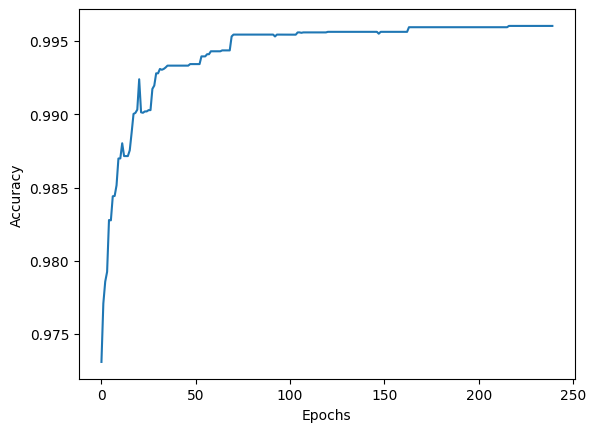

[1 1 1 ... 0 1 0]
[1 1 1 ... 0 1 0]
Accuracy: 1.0


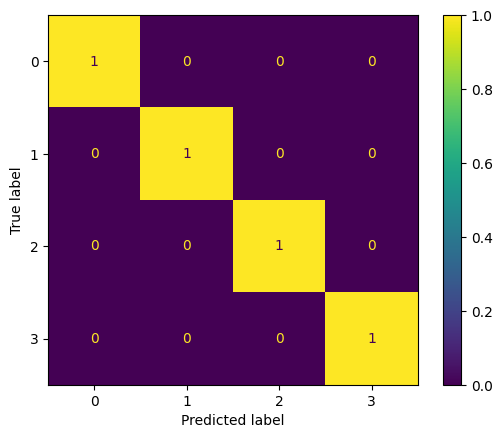

In [16]:
plot_accuracy(last_layer_accuracy, "Training Accuracy Last Layer Best Model", "best_model")
print_accuracy(model.predict_accumulated_goodness(x_test.to(device)), y_test)


### Small FFNN

In [19]:
# Best small model hyperparameters
ar_small = [9,30,30,30,30]
th_small = 0.5
lr_small = 0.01
epochs = 240
batch_size = 64
lr_decay = 0

print(f"Best small model: {ar_small}, thr={th_small}, lr={lr_small}, batch_size={batch_size}, lr_decay={lr_decay}")

model = FFNN(
    device=device,
    layers=ar_small,
    threshold=th_small,
    learning_rate=lr_small,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

Best small model: [9, 30, 30, 30, 30], thr=0.5, lr=0.01, batch_size=64, lr_decay=0


In [20]:
last_layer_accuracy_small = model.train(x_pos, x_neg)
model.save_model('../models/best_small_model.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 240/240 [12:04<00:00,  3.02s/it]



Training Layer: 2
----------------------------------------


100%|██████████| 240/240 [11:42<00:00,  2.93s/it]



Training Layer: 3
----------------------------------------


100%|██████████| 240/240 [11:35<00:00,  2.90s/it]



Training Layer: 4
----------------------------------------


100%|██████████| 240/240 [11:36<00:00,  2.90s/it]


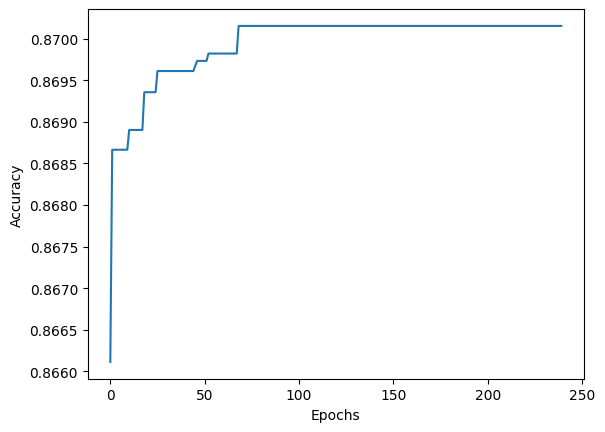

[1 1 1 ... 0 1 0]
[1 0 1 ... 0 1 0]
Accuracy: 0.8301035165786743


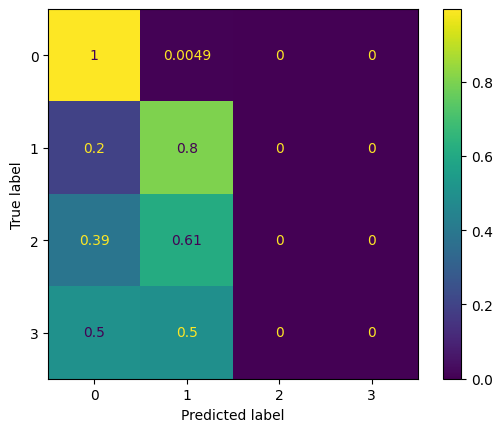

In [21]:
plot_accuracy(last_layer_accuracy_small, "Training Accuracy Last Layer Best Small Model", "best_small_model")
print_accuracy(model.predict_accumulated_goodness(x_test.to(device)), y_test)

### FFNN with Softmax Classifier

In [22]:
# Create equal model with classifier
model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.load_model('../models/best_model.pth')

In [23]:
classifier_layer_accuracy = model.train_classifier(x_train.to(device), y_train_OH.to(device), epochs, batch_size)
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')


Training Softmax
----------------------------------------


100%|██████████| 240/240 [05:48<00:00,  1.45s/it]


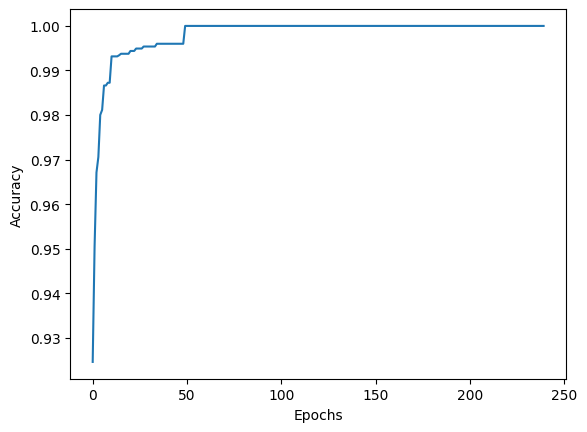

[1 1 1 ... 0 1 0]
[1 1 1 ... 0 1 0]
Accuracy: 1.0


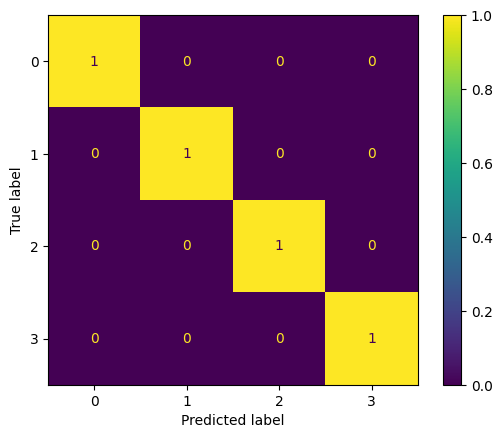

In [24]:
plot_accuracy(classifier_layer_accuracy, "Training Loss Classifier", "classifier")
print_accuracy(model.predict_classifier(x_test.to(device)),y_test)

## Backpropagation

In [25]:
def train(model, x, y, epochs, loss_function, optimizer, batch_size):
    
    model.train()
    num_batches = len(x) // batch_size
    
    total_accuracy = []
    for epoch in range(epochs):
        losses = []
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        accuracy = model(x).argmax(1).eq(torch.argmax(y, dim=1)).float().mean().item()   
        total_accuracy.append(accuracy)
        print(f"epoch: {epoch + 1}/{epochs} avg. loss: {sum(losses)/len(losses)}")
        
    return total_accuracy

In [26]:
def test(model, x_test, y_test, loss_function):
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = loss_function(predictions, y_test).item()
        
    print(f"avg. test loss: {test_loss}")   
    
def predict_actions(model, x):
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        return predictions.argmax(1)

In [27]:
from backpropNN import BackpropNN

input_size = 5
output_size = 4

# hyperparameters
hidden_size = 30
activation_function = nn.ReLU()
epochs = 100
batch_size = 64
learning_rate = 0.001

# fully connected neural network with 4 hidden layers
backprop_model = BackpropNN(input_size, output_size, hidden_size, activation_function)

optimizer = torch.optim.Adam(backprop_model.parameters(), lr=learning_rate);
loss_fn = nn.CrossEntropyLoss()

In [28]:
backprop_accuracy = train(backprop_model, x_train, y_train_OH, epochs, loss_fn, optimizer, batch_size)
torch.save(backprop_model.state_dict(), '../models/backprop_model.pth')

epoch: 1/100 avg. loss: 0.4487324782327957
epoch: 2/100 avg. loss: 0.22289918703172176
epoch: 3/100 avg. loss: 0.15620104245387714
epoch: 4/100 avg. loss: 0.09934402173965452
epoch: 5/100 avg. loss: 0.06301906083152489
epoch: 6/100 avg. loss: 0.04286811135019368
epoch: 7/100 avg. loss: 0.030470943591137292
epoch: 8/100 avg. loss: 0.02887100029556033
epoch: 9/100 avg. loss: 0.023110320262930643
epoch: 10/100 avg. loss: 0.017563065815420872
epoch: 11/100 avg. loss: 0.01589370350526126
epoch: 12/100 avg. loss: 0.017090467120646997
epoch: 13/100 avg. loss: 0.00932009141930038
epoch: 14/100 avg. loss: 0.016212786334177953
epoch: 15/100 avg. loss: 0.009190967185387635
epoch: 16/100 avg. loss: 0.011523364050329681
epoch: 17/100 avg. loss: 0.010298276340100984
epoch: 18/100 avg. loss: 0.01156974300955708
epoch: 19/100 avg. loss: 0.014136207986205516
epoch: 20/100 avg. loss: 0.005369484685082714
epoch: 21/100 avg. loss: 0.008009636233898857
epoch: 22/100 avg. loss: 0.007997674468111221
epoch: 2

In [29]:
test(backprop_model, x_test, y_test_OH, loss_fn)

avg. test loss: 0.0003180935455020517


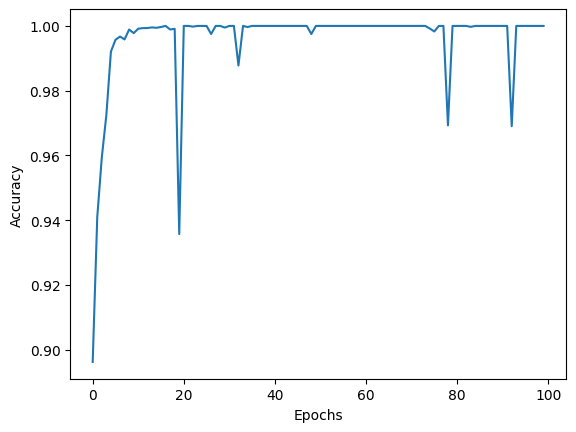

1.0


In [30]:
plot_accuracy(backprop_accuracy, "Training Accuracy Backprop Model", "backprop_model")
accuracy = predict_actions(backprop_model, x_test).eq(torch.from_numpy(y_test)).float().mean().item()
print(accuracy)

## FFNN Blackjack

In [5]:
random_basic_rewards = np.loadtxt('../data/random_basic_strategy_rewards.csv', delimiter=',')
rewards_random = random_basic_rewards[0]
rewards_basic_strategy = random_basic_rewards[1]

### FFNN & Backpropagation

100%|██████████| 75000/75000 [11:11<00:00, 111.67it/s]


Average Reward:  -0.013026666666666667
Variance:  1.2878341437444598


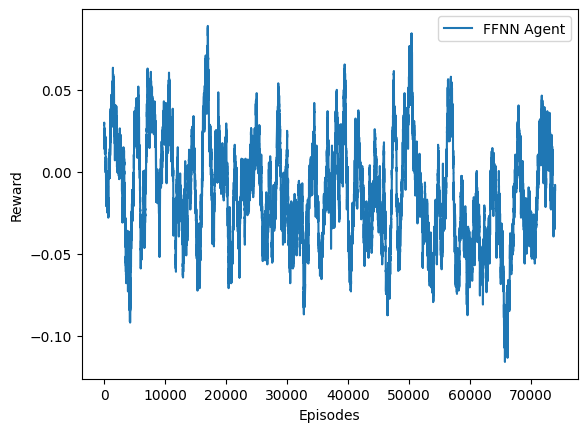

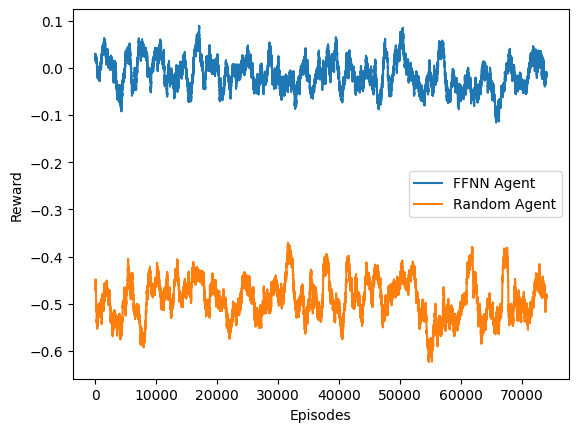

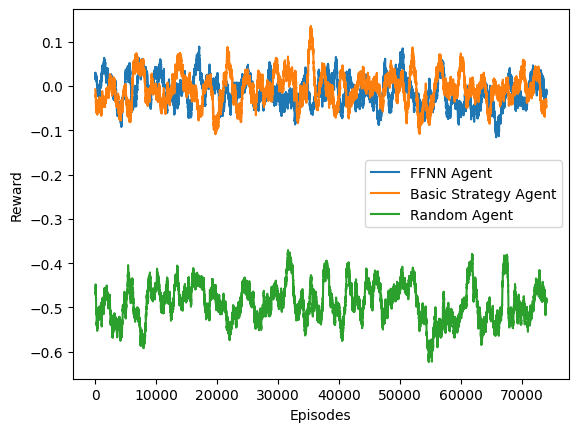

In [8]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = architecture_best
threshold = threshold_best
lr = learning_rate_best

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_FFNN], "FFNN Agent", "ffnn_agent", ["FFNN Agent"])
plot_reward([rewards_FFNN, rewards_random], "FFNN Agent", "ffnn_random_agent", ["FFNN Agent", "Random Agent"])
plot_reward([rewards_FFNN, rewards_basic_strategy, rewards_random], "FFNN Agent", "ffnn_random_basic_agent", ["FFNN Agent", "Basic Strategy Agent", "Random Agent"])

100%|██████████| 75000/75000 [00:32<00:00, 2322.86it/s]


Average Reward:  -0.012373333333333333
Variance:  1.2767772576525374


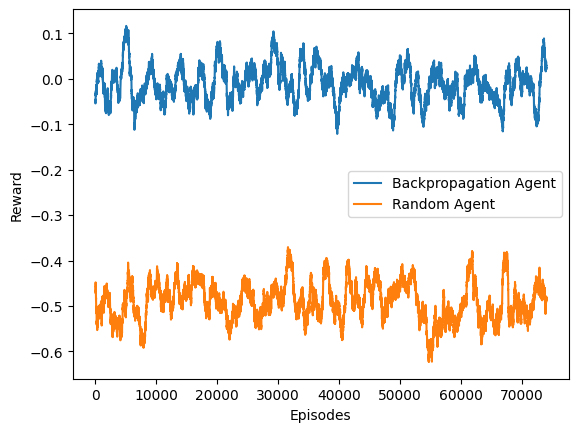

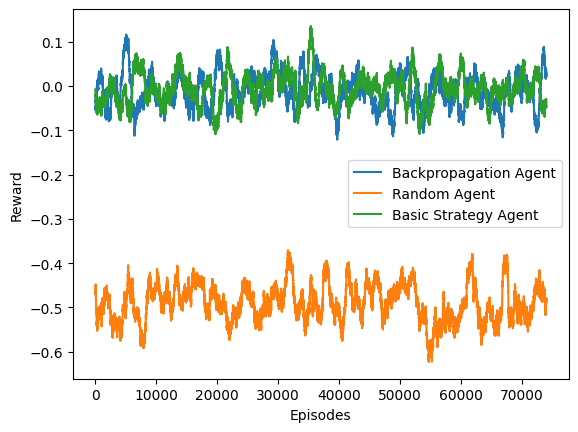

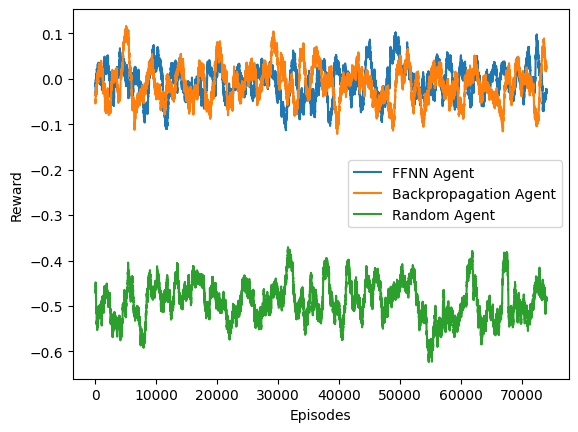

In [33]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_BP = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_BP, rewards_random], "Backpropagation Agent", "backprop_random_agent", ["Backpropagation Agent", "Random Agent"])
plot_reward([rewards_BP, rewards_random, rewards_basic_strategy], "Backpropagation Agent", "backprop_random_basic_agent", ["Backpropagation Agent", "Random Agent", "Basic Strategy Agent"])
plot_reward([rewards_FFNN, rewards_BP, rewards_random], "Backpropagation Agent", "ffnn_backprop_random_agent", ["FFNN Agent", "Backpropagation Agent", "Random Agent"])

### DQFFL


Run 1
----------------------------------------


100%|██████████| 4000/4000 [07:57<00:00,  8.37it/s]



Run 2
----------------------------------------


100%|██████████| 4000/4000 [07:26<00:00,  8.96it/s]



Run 3
----------------------------------------


100%|██████████| 4000/4000 [07:29<00:00,  8.90it/s]



Run 4
----------------------------------------


100%|██████████| 4000/4000 [07:16<00:00,  9.17it/s]



Run 5
----------------------------------------


100%|██████████| 4000/4000 [07:20<00:00,  9.07it/s]


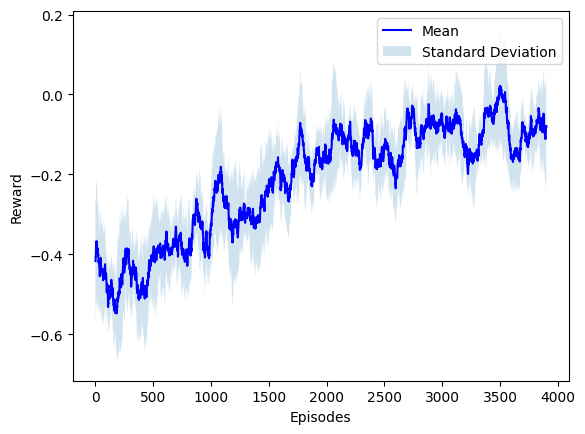

In [6]:
# DQFFL hyperparameters
layers = [9,1000,1000,1000,1000]
threshold = 0.5
lr = 0.001

#RL hyperparameters
episodes = 4000 
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 32
update_td_target = 50
buffer_size = 10000

total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgentBJ(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size,
        filename="dqffnn_agent"
    )
    rewards_DQFFNN = play_game(env, episodes, agent, collect_data, print_rewards=False)
    total_rewards.append(rewards_DQFFNN)
    
agent.model.save_model(path='../models/DQFFNN_model.pth')
plot_reward(total_rewards, "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["DQFFNN Agent"], plot_variance=True, rolling_length=100)

[1 1 1 ... 0 1 0]
[1 0 1 ... 0 1 0]
Accuracy: 0.6842314600944519


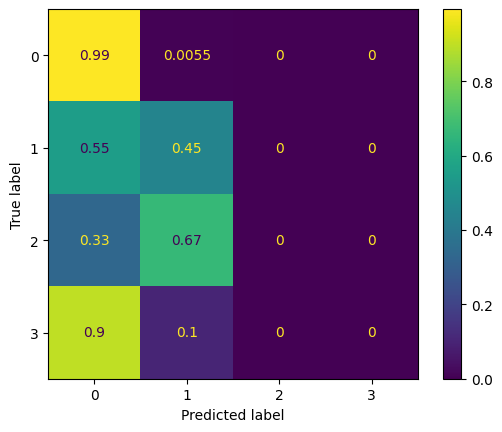

In [15]:
print_accuracy(agent.model.predict_accumulated_goodness(x_test.to(device)), y_test)


Run 1
----------------------------------------


100%|██████████| 4000/4000 [00:00<00:00, 4570.68it/s]



Run 2
----------------------------------------


100%|██████████| 4000/4000 [00:00<00:00, 4783.67it/s]



Run 3
----------------------------------------


100%|██████████| 4000/4000 [00:00<00:00, 4413.85it/s]



Run 4
----------------------------------------


100%|██████████| 4000/4000 [00:00<00:00, 4627.80it/s]



Run 5
----------------------------------------


100%|██████████| 4000/4000 [00:00<00:00, 4801.51it/s]


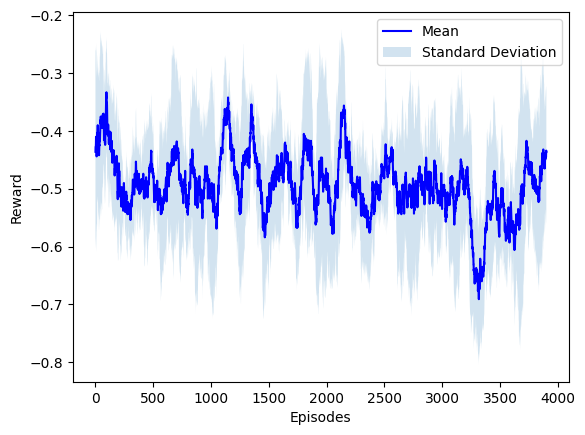

In [16]:
dqffn_random_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    
    agent = RandomAgent(env, filename="random_agent_DQFFNN")
    rewards_random_dqffn = play_game(env, episodes, agent, False, False)
    dqffn_random_rewards.append(rewards_random_dqffn)
    
plot_reward(dqffn_random_rewards, "Random Agent", "random_agent_DQFFNN", ["Random Agent"], plot_variance=True, rolling_length=100)

#### Frozen Lake


Run 1
----------------------------------------


100%|██████████| 2000/2000 [02:49<00:00, 11.80it/s]



Run 2
----------------------------------------


100%|██████████| 2000/2000 [02:49<00:00, 11.80it/s]



Run 3
----------------------------------------


100%|██████████| 2000/2000 [02:41<00:00, 12.40it/s]



Run 4
----------------------------------------


100%|██████████| 2000/2000 [02:49<00:00, 11.83it/s]



Run 5
----------------------------------------


100%|██████████| 2000/2000 [02:54<00:00, 11.49it/s]


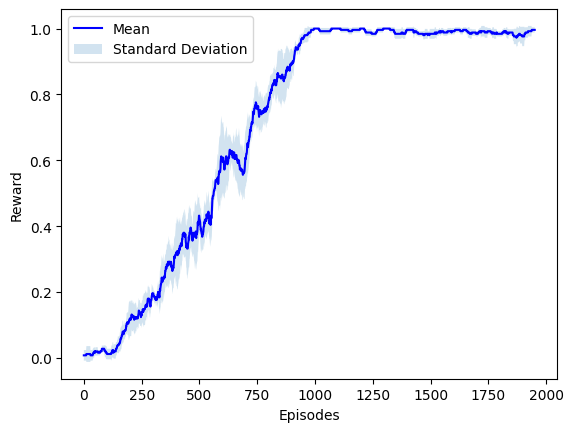

In [10]:
layers = [20,100,100,100]
threshold = 0.1
lr = 0.001

#RL hyperparameters
episodes = 2000
epsilon = 0.99
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.9
batch_size = 32
update_td_target = 10
buffer_size = 1000

env = gym.make("FrozenLake-v1", max_episode_steps=100, desc=None, map_name="4x4", is_slippery=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)


total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgent(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size
    )

    play_game(env, episodes, agent, False, False, True)
    rewards = np.array(env.return_queue).flatten()
    total_rewards.append(rewards)

average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)
agent.model.save_model(path='../models/FrozenLake_DQFFNN_model.pth')

#print("Rewards: ", rewards)
# print("Average Reward: ", average_reward)
# print("Variance: ", variance)
plot_reward(total_rewards, "FrozenLake", f"FrozenLake_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["Frozen Lake"],plot_variance=True , rolling_length=50)